In [73]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [74]:
!pip install catboost xgboost optuna

In [75]:

# Load dataset
df = pd.read_csv("./movies_metadata.csv", low_memory=False)
ratings_df = pd.read_csv("./ratings_average.csv")

# 1. Cleaning Genre Data
def parse_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        if isinstance(genres, list) and len(genres) > 0:
            return [genre['name'] for genre in genres if 'name' in genre]
    except (ValueError, SyntaxError):
        pass
    return []

df['parsed_genres'] = df['genres'].apply(parse_genres)

# 2. Cleaning Budget and Revenue
def clean_numeric(value):
    try:
        val = int(value)
        if val == 0 or val < 1000:
            return np.nan  # Treat 0 as missing value
        return val
    except (ValueError, TypeError):
        return np.nan

df['budget_cleaned'] = df['budget'].apply(clean_numeric)
df['revenue_cleaned'] = df['revenue'].apply(clean_numeric)

In [76]:
# 3. Cleaning Release Date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Drop rows where budget or revenue is NaN or release date is missing
df_cleaned = df.dropna(subset=['budget_cleaned', 'revenue_cleaned', 'release_date'])

# Extract month and day from release date
df_cleaned['release_month'] = df_cleaned['release_date'].dt.month
df_cleaned['release_day'] = df_cleaned['release_date'].dt.day

# Step 5: Target variable (revenue/budget ratio)
df_cleaned['revenue_budget_ratio'] = df_cleaned['revenue_cleaned'] / df_cleaned['budget_cleaned']

<ipython-input-76-e0701946e48d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['release_month'] = df_cleaned['release_date'].dt.month
<ipython-input-76-e0701946e48d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['release_day'] = df_cleaned['release_date'].dt.day
<ipython-input-76-e0701946e48d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [77]:
for i in df_cleaned['revenue_budget_ratio']:
  if i > 1000: print(df_cleaned['budget_cleaned'].loc[df_cleaned['revenue_budget_ratio'] == i])

2595    60000.0
Name: budget_cleaned, dtype: float64
14192    15000.0
Name: budget_cleaned, dtype: float64
41472    5000.0
Name: budget_cleaned, dtype: float64


In [78]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = df_cleaned['revenue_budget_ratio'].quantile(0.25)
Q3 = df_cleaned['revenue_budget_ratio'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
df_cleaned = df_cleaned[(df_cleaned['revenue_budget_ratio'] >= lower_bound) &
                                    (df_cleaned['revenue_budget_ratio'] <= upper_bound)]

# Verify the shape of the cleaned dataframe
print(df_cleaned.shape)

(4833, 30)


In [79]:


# Step 6: Add ratings data

# Merge the two DataFrames on movieId and id
df_cleaned['id'] = pd.to_numeric(df_cleaned['id'], errors='coerce')  # Ensure 'id' is numeric to match 'movieId'
merged_df = pd.merge(df_cleaned, ratings_df, left_on='id', right_on='movieId', how='left')

# Function to calculate the weighted vote average
def update_vote_average(row):
    if pd.isna(row['vote_average']) or row['vote_average'] == 0:
        return row['average_rating']  # Replace with average_rating if vote_average is NaN or 0
    if pd.notna(row['average_rating']):  # If both are present, calculate weighted average
        vote_weight = row['vote_count'] if pd.notna(row['vote_count']) else 0
        rating_weight = row['rating_count']
        total_weight = vote_weight + rating_weight
        return ((row['vote_average'] * vote_weight) + (row['average_rating'] * 2 * rating_weight)) / total_weight
    return row['vote_average']  # If no update is needed, return the original vote_average

# Apply the update_vote_average function to each row
merged_df['vote_average_updated'] = merged_df.apply(update_vote_average, axis=1)
merged_df['vote_count'] = merged_df['vote_count'] + merged_df['rating_count']

# Drop extra columns like movieId from the merged DataFrame
merged_df.drop(columns=['movieId', 'average_rating', 'rating_count'], inplace=True)

merged_df.dropna(subset = ["vote_average_updated", "vote_count", "revenue_budget_ratio"], inplace=True)

<ipython-input-79-e90d2c634235>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['id'] = pd.to_numeric(df_cleaned['id'], errors='coerce')  # Ensure 'id' is numeric to match 'movieId'


In [80]:
# Step 6: Prepare Features and Labels
X = merged_df[['release_month', 'release_day']]  # Use month, day, vote count as initial features

# Prepare the multi-output labels (targets)
y = merged_df[['revenue_budget_ratio', 'vote_average_updated', 'vote_count']]

In [81]:
print(X.shape, y.shape)

(1354, 2) (1354, 3)


In [82]:
# Step 7: Encode genres as categorical variables
encoder = OneHotEncoder()
genre_list = merged_df['parsed_genres'].apply(lambda x: ','.join(x) if isinstance(x, list) else '')
genres_encoded = encoder.fit_transform(genre_list.values.reshape(-1, 1)).toarray()
genre_feature_names = encoder.get_feature_names_out(['parsed_genres'])

genres_encoded_df = pd.DataFrame(genres_encoded, columns=genre_feature_names)

# Concatenate genre-encoded features to X
X = pd.concat([X, genres_encoded_df], axis=1)


In [83]:
# Step 7.1: Drop rows with NaN values
# First, check for any NaN values in X or y
print("Missing values in X before drop:", X.isna().sum().sum())
print("Missing values in y before drop:", y.isna().sum().sum())

# Drop rows with NaN values from both X and y
X_cleaned = X.dropna()
y_cleaned = y.dropna()

# Ensure that X and y have the same number of rows after dropping NaNs
X_cleaned, y_cleaned = X_cleaned.align(y_cleaned, join='inner', axis=0)

print("Missing values in X after drop:", X_cleaned.isna().sum().sum())
print("Missing values in y after drop:", y_cleaned.isna().sum().sum())

Missing values in X before drop: 413946
Missing values in y before drop: 0
Missing values in X after drop: 0
Missing values in y after drop: 0


In [84]:
print(X_cleaned.shape, y_cleaned.shape)

(561, 522) (561, 3)


In [85]:
X_cleaned.columns

Index(['release_month', 'release_day', 'parsed_genres_',
       'parsed_genres_Action', 'parsed_genres_Action,Adventure',
       'parsed_genres_Action,Adventure,Comedy',
       'parsed_genres_Action,Adventure,Comedy,Crime,Thriller',
       'parsed_genres_Action,Adventure,Comedy,Drama,Mystery',
       'parsed_genres_Action,Adventure,Comedy,Drama,Western',
       'parsed_genres_Action,Adventure,Comedy,Family,Fantasy',
       ...
       'parsed_genres_Thriller,Science Fiction,Mystery,Romance',
       'parsed_genres_War',
       'parsed_genres_War,Crime,Drama,Mystery,Romance,Thriller',
       'parsed_genres_War,Drama', 'parsed_genres_War,Drama,History',
       'parsed_genres_War,Drama,History,Adventure,Romance,Thriller',
       'parsed_genres_War,History,Action,Adventure,Drama,Romance',
       'parsed_genres_Western', 'parsed_genres_Western,Adventure',
       'parsed_genres_Western,Thriller'],
      dtype='object', length=522)

In [86]:
print(y['vote_count'])

0        2536.0
2        4231.0
4        2513.0
7       14025.0
8       10506.0
         ...   
4806       30.0
4816       93.0
4823       58.0
4824       86.0
4826       95.0
Name: vote_count, Length: 1354, dtype: float64


In [87]:
print(y.info)

<bound method DataFrame.info of       revenue_budget_ratio  vote_average_updated  vote_count
0                 4.043035              6.930087      2536.0
2                 3.123947              7.761569      4231.0
4                 6.072311              6.012495      2513.0
7                 0.102218              7.403558     14025.0
8                 2.232930              7.128726     10506.0
...                    ...                   ...         ...
4806              3.237833              5.640000        30.0
4816              4.184134              6.431183        93.0
4823              5.833044              6.443103        58.0
4824              4.000000              5.287209        86.0
4826              1.097910              7.084211        95.0

[1354 rows x 3 columns]>


In [88]:
print(max(y['vote_count']), min(y['vote_count']))

90078.0 2.0


In [89]:
y.iloc[0]

,0
revenue_budget_ratio,4.043035
vote_average_updated,6.930087
vote_count,2536.000000


In [90]:
y['revenue_budget_ratio'].info

<bound method Series.info of 0       4.043035
2       3.123947
4       6.072311
7       0.102218
8       2.232930
          ...   
4806    3.237833
4816    4.184134
4823    5.833044
4824    4.000000
4826    1.097910
Name: revenue_budget_ratio, Length: 1354, dtype: float64>

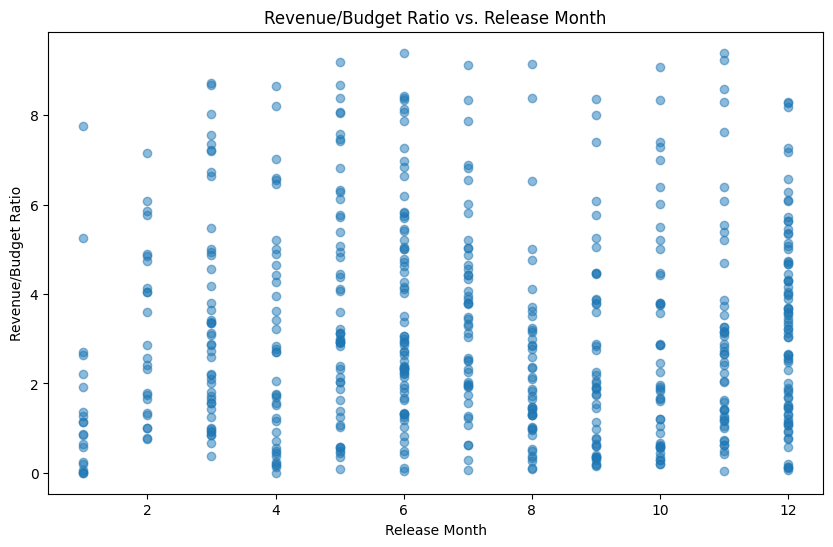

In [91]:
# Plot y against X months and days

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned['release_month'], y_cleaned['revenue_budget_ratio'], alpha=0.5)
plt.xlabel('Release Month')
plt.ylabel('Revenue/Budget Ratio')
plt.title('Revenue/Budget Ratio vs. Release Month')

plt.show()

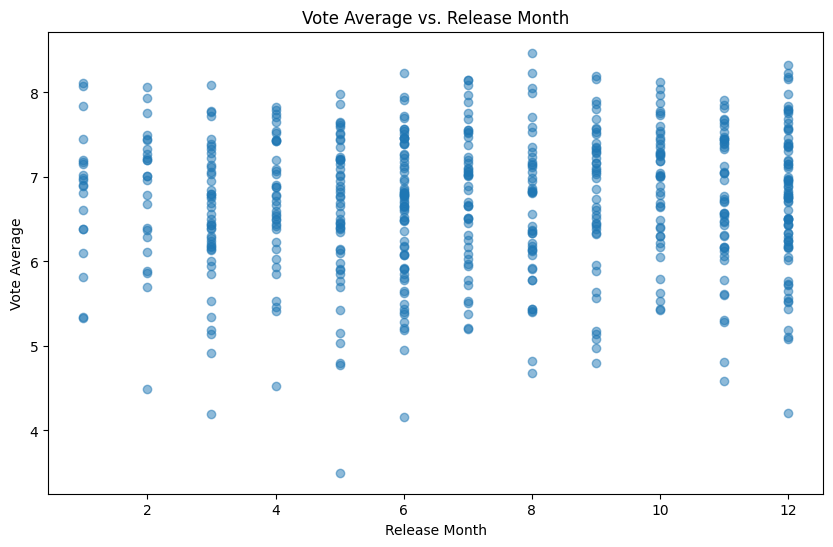

In [92]:
# Plot y against X months and days

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned['release_month'], y_cleaned['vote_average_updated'], alpha=0.5)
plt.xlabel('Release Month')
plt.ylabel('Vote Average')
plt.title('Vote Average vs. Release Month')
plt.show()

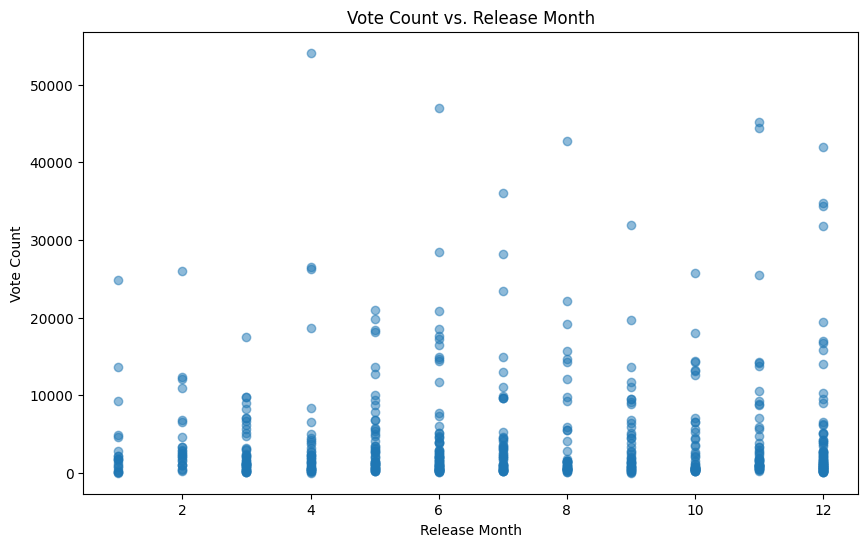

In [93]:
# Plot y against X months and days

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned['release_month'], y_cleaned['vote_count'], alpha=0.5)
plt.xlabel('Release Month')
plt.ylabel('Vote Count')
plt.title('Vote Count vs. Release Month')
plt.show()

In [107]:
# Extract year and month from release date
df_cleaned['release_year'] = df_cleaned['release_date'].dt.year
df_cleaned['release_month'] = df_cleaned['release_date'].dt.month

# Preview the updated DataFrame
df_cleaned[['release_year', 'release_month', 'revenue_budget_ratio', 'vote_average']].head()

,release_year,release_month,revenue_budget_ratio,vote_average
1,1995,12,4.043035,6.9
3,1995,12,5.090760,6.1
5,1995,12,3.123947,7.7
8,1995,12,1.838576,5.5
9,1995,11,6.072311,6.6


In [108]:
# Group by year and month, and calculate the mean of revenue/budget ratio and vote_average
year_month_avg = df_cleaned.groupby(['release_year', 'release_month']).agg({
    'revenue_budget_ratio': 'mean',
    'vote_average': 'mean'
}).reset_index()

# Preview the grouped data
year_month_avg.head()

,release_year,release_month,revenue_budget_ratio,vote_average
0,1915,12,7.935128,4.8
1,1922,1,0.363818,6.4
2,1924,3,1.068882,7.4
3,1925,6,2.708559,7.7
4,1925,9,6.834951,5.8


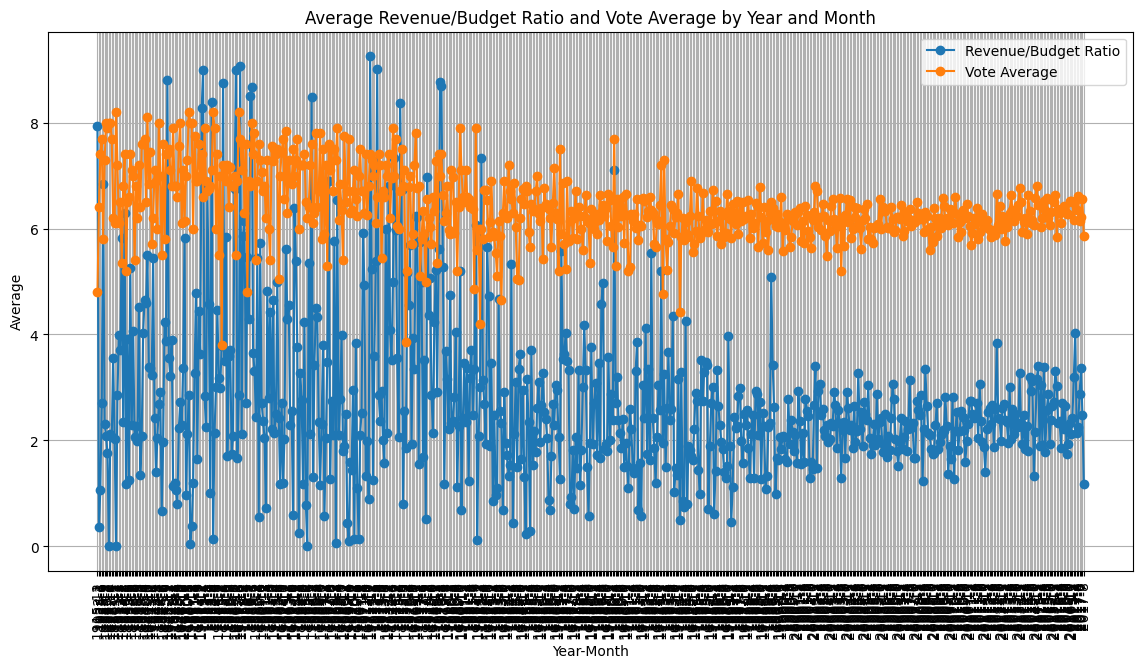

In [109]:
plt.figure(figsize=(14, 7))

# Plot Revenue/Budget Ratio over time
plt.plot(year_month_avg['release_year'].astype(str) + '-' + year_month_avg['release_month'].astype(str),
         year_month_avg['revenue_budget_ratio'], marker='o', label='Revenue/Budget Ratio')

# Plot Vote Average over time
plt.plot(year_month_avg['release_year'].astype(str) + '-' + year_month_avg['release_month'].astype(str),
         year_month_avg['vote_average'], marker='o', label='Vote Average')

plt.xticks(rotation=90)  # Rotate x-axis labels to make them readable
plt.xlabel('Year-Month')
plt.ylabel('Average')
plt.title('Average Revenue/Budget Ratio and Vote Average by Year and Month')
plt.legend()
plt.grid(True)
plt.show()

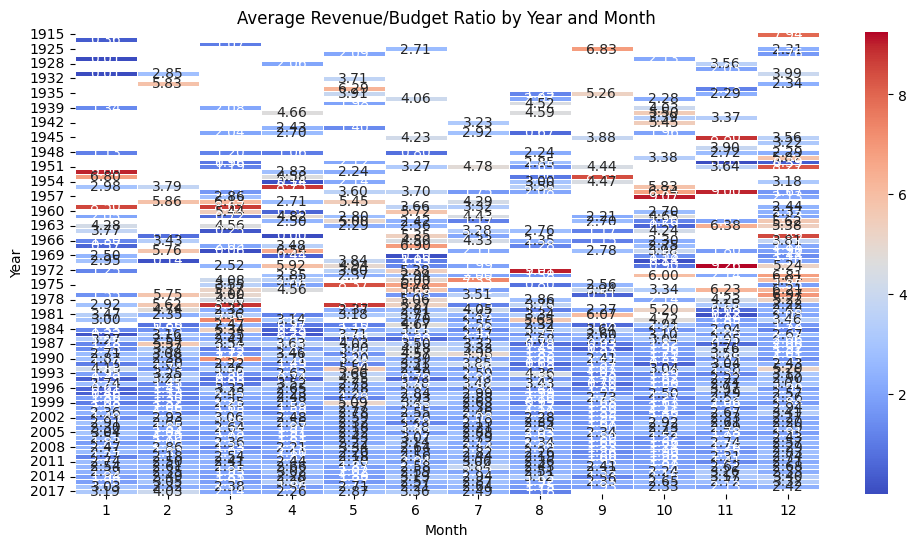

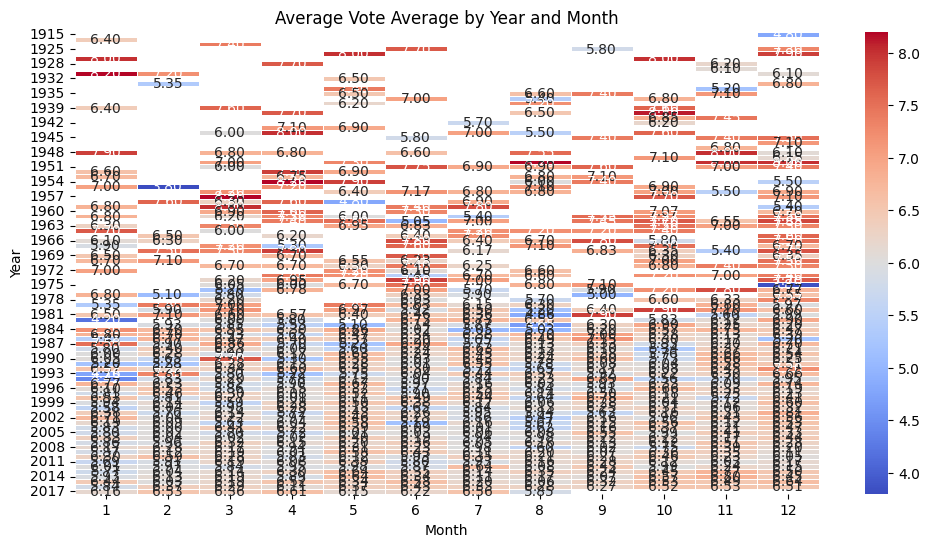

In [110]:
import seaborn as sns

# Pivot the DataFrame for heatmap (Year vs Month)
pivot_revenue = year_month_avg.pivot(index='release_year', columns='release_month', values='revenue_budget_ratio')
pivot_vote = year_month_avg.pivot(index='release_year', columns='release_month', values='vote_average')

# Plot heatmap for Revenue/Budget Ratio
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_revenue, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Average Revenue/Budget Ratio by Year and Month')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()

# Plot heatmap for Vote Average
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_vote, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Average Vote Average by Year and Month')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()

In [112]:
from scipy.stats import pearsonr

# Pearson correlation and p-value for revenue_budget_ratio vs release_year
corr, p_value = pearsonr(df_cleaned['revenue_budget_ratio'], df_cleaned['release_year'])
print(f"Pearson correlation: {corr}, P-value: {p_value}")

Pearson correlation: -0.11046687871954107, P-value: 1.34767176245432e-14


In [113]:
from scipy.stats import spearmanr

# Spearman correlation and p-value for revenue_budget_ratio vs release_year
corr, p_value = spearmanr(df_cleaned['revenue_budget_ratio'], df_cleaned['release_year'])
print(f"Spearman correlation: {corr}, P-value: {p_value}")

Spearman correlation: -0.05270367364117995, P-value: 0.0002468098460077448


In [114]:
from scipy.stats import ttest_ind

# Perform t-test to compare the means of revenue_budget_ratio for two different years
year_2010 = df_cleaned[df_cleaned['release_year'] == 2010]['revenue_budget_ratio']
year_2015 = df_cleaned[df_cleaned['release_year'] == 2015]['revenue_budget_ratio']

t_stat, p_value = ttest_ind(year_2010, year_2015, nan_policy='omit')
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.1283339960837337, P-value: 0.033911052167366916


Slope: -0.01600104638850986, Intercept: 34.38876031443956


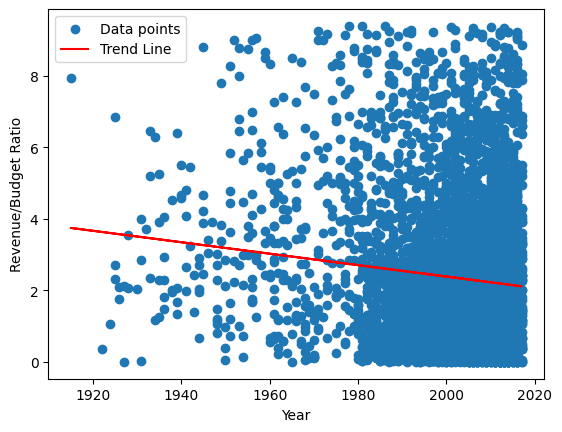

In [115]:
from sklearn.linear_model import LinearRegression

# Prepare the data
X_year = df_cleaned[['release_year']].values
y_revenue_ratio = df_cleaned['revenue_budget_ratio'].values

# Fit the linear regression model
regressor = LinearRegression()
regressor.fit(X_year, y_revenue_ratio)

# Get the slope (coefficient) and intercept
slope = regressor.coef_[0]
intercept = regressor.intercept_

print(f"Slope: {slope}, Intercept: {intercept}")

# Predict and plot the trend line
y_pred = regressor.predict(X_year)

plt.scatter(X_year, y_revenue_ratio, label='Data points')
plt.plot(X_year, y_pred, color='red', label='Trend Line')
plt.xlabel('Year')
plt.ylabel('Revenue/Budget Ratio')
plt.legend()
plt.show()

In [94]:
# Step 8: Train-Test Split with cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [95]:

# Step 9: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [96]:
# Step 10: Train a RandomForest model for Multi-Output Regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 11: Evaluate the model
y_pred = model.predict(X_test_scaled)

# Calculate Mean Squared Error for each target
mse_revenue = mean_squared_error(y_test['revenue_budget_ratio'], y_pred[:, 0])
mse_vote_average = mean_squared_error(y_test['vote_average_updated'], y_pred[:, 1])
mse_vote_count = mean_squared_error(y_test['vote_count'], y_pred[:, 2])

print(f"Mean Squared Error for Revenue/Budget Ratio: {mse_revenue}")
print(f"Mean Squared Error for Vote Average: {mse_vote_average}")
print(f"Mean Squared Error for Vote Count: {mse_vote_count}")

Mean Squared Error for Revenue/Budget Ratio: 6.359084367508955
Mean Squared Error for Vote Average: 0.7034489941580355
Mean Squared Error for Vote Count: 75596549.33484383


In [97]:
y['revenue_budget_ratio']

,revenue_budget_ratio
0,4.043035
2,3.123947
4,6.072311
7,0.102218
8,2.232930
...,...
4806,3.237833
4816,4.184134
4823,5.833044
4824,4.000000


In [98]:
y['vote_count']

,vote_count
0,2536.0
2,4231.0
4,2513.0
7,14025.0
8,10506.0
...,...
4806,30.0
4816,93.0
4823,58.0
4824,86.0


In [99]:
# Fine-tuning model
from catboost import CatBoostRegressor

# Step 10: Use CatBoost for Multi-Output Regression
model_catboost = CatBoostRegressor(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiRMSE', random_state=42, verbose=0)
model_catboost.fit(X_train_scaled, y_train)

# Step 11: Evaluate CatBoost model
y_pred_catboost = model_catboost.predict(X_test_scaled)

# Calculate Mean Squared Error for each target
mse_revenue_catboost = mean_squared_error(y_test['revenue_budget_ratio'], y_pred_catboost[:, 0])
mse_vote_average_catboost = mean_squared_error(y_test['vote_average_updated'], y_pred_catboost[:, 1])
mse_vote_count_catboost = mean_squared_error(y_test['vote_count'], y_pred_catboost[:, 2])

print(f"CatBoost - MSE for Revenue/Budget Ratio: {mse_revenue_catboost}")
print(f"CatBoost - MSE for Vote Average: {mse_vote_average_catboost}")
print(f"CatBoost - MSE for Vote Count: {mse_vote_count_catboost}")

CatBoost - MSE for Revenue/Budget Ratio: 6.252161408574684
CatBoost - MSE for Vote Average: 0.7379358219806893
CatBoost - MSE for Vote Count: 67953877.12849113


In [100]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# Step 10: Use XGBoost for Multi-Output Regression
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb = MultiOutputRegressor(xgb_model)
model_xgb.fit(X_train_scaled, y_train)

# Step 11: Evaluate XGBoost model
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Calculate Mean Squared Error for each target
mse_revenue_xgb = mean_squared_error(y_test['revenue_budget_ratio'], y_pred_xgb[:, 0])
mse_vote_average_xgb = mean_squared_error(y_test['vote_average_updated'], y_pred_xgb[:, 1])
mse_vote_count_xgb = mean_squared_error(y_test['vote_count'], y_pred_xgb[:, 2])

print(f"XGBoost - MSE for Revenue/Budget Ratio: {mse_revenue_xgb}")
print(f"XGBoost - MSE for Vote Average: {mse_vote_average_xgb}")
print(f"XGBoost - MSE for Vote Count: {mse_vote_count_xgb}")

XGBoost - MSE for Revenue/Budget Ratio: 6.051029269223832
XGBoost - MSE for Vote Average: 0.6746339453488835
XGBoost - MSE for Vote Count: 73252235.43389867


In [101]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for CatBoost
param_grid = {
    'depth': [6, 8, 10],
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Random search of parameters, using 3-fold cross-validation
random_search_catboost = RandomizedSearchCV(CatBoostRegressor(loss_function='MultiRMSE', random_state=42), param_grid, n_iter=10, cv=3, verbose=0, random_state=42)

# Fit the random search model
random_search_catboost.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best Params (CatBoost):", random_search_catboost.best_params_)
print("Best Score (CatBoost):", random_search_catboost.best_score_)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2:	learn: 7455.9139751	total: 21.7ms	remaining: 701ms
3:	learn: 7425.9201461	total: 27ms	remaining: 649ms
4:	learn: 7398.4292170	total: 33.1ms	remaining: 630ms
5:	learn: 7382.7832749	total: 39.3ms	remaining: 616ms
6:	learn: 7353.3604109	total: 44.4ms	remaining: 590ms
7:	learn: 7326.0019309	total: 50.5ms	remaining: 580ms
8:	learn: 7302.6154567	total: 56.3ms	remaining: 569ms
9:	learn: 7265.7366595	total: 61.9ms	remaining: 557ms
10:	learn: 7247.2515961	total: 67.4ms	remaining: 545ms
11:	learn: 7239.7608483	total: 69.7ms	remaining: 511ms
12:	learn: 7222.0484539	total: 74.7ms	remaining: 500ms
13:	learn: 7214.7832919	total: 79.3ms	remaining: 487ms
14:	learn: 7175.8848489	total: 86.2ms	remaining: 488ms
15:	learn: 7156.9623048	total: 91.5ms	remaining: 481ms
16:	learn: 7139.2314782	total: 96.2ms	remaining: 470ms
17:	learn: 7127.7727937	total: 101ms	remaining: 460ms
18:	learn: 7107.9171688	total: 106ms	remaining: 450ms
19:	learn: 7086.3167132	total: 110ms	rema

In [102]:
from sklearn.model_selection import cross_val_score

# Evaluate model with cross-validation (e.g., CatBoost)
catboost_model = CatBoostRegressor(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiRMSE', random_state=42, verbose=0)
cv_scores = cross_val_score(catboost_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

print("Cross-Validation Scores (CatBoost):", -cv_scores)
print("Mean CV Score:", -np.mean(cv_scores))

Cross-Validation Scores (CatBoost): [13112141.50100479 25196175.70004172 31916807.26604361 18554770.83580808
 19154358.11044919]
Mean CV Score: 21586850.68266948


In [116]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Step 1: Define the Optuna objective function
def objective(trial):
    # Suggest values for hyperparameters
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    iterations = trial.suggest_int('iterations', 100, 1000)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)

    # Create the model with suggested hyperparameters
    model = CatBoostRegressor(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=0
    )

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate the Mean Squared Error for the first target (revenue_budget_ratio)
    mse = mean_squared_error(y_test['revenue_budget_ratio'], y_pred[:, 0])

    return mse

# Step 2: Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Step 3: Print the best parameters
print("Best hyperparameters: ", study.best_params)

# Step 4: Train the final model with the best parameters
best_params = study.best_params
model_catboost = CatBoostRegressor(
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    iterations=best_params['iterations'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    loss_function='MultiRMSE',
    random_state=42,
    verbose=0
)

model_catboost.fit(X_train_scaled, y_train)
y_pred_best = model_catboost.predict(X_test_scaled)

# Evaluate the final model
mse_final = mean_squared_error(y_test['revenue_budget_ratio'], y_pred_best[:, 0])
print(f"Final MSE: {mse_final}")

[I 2024-10-05 17:01:14,387] A new study created in memory with name: no-name-89c846ae-39ca-4be9-9879-0485c350a62d
[I 2024-10-05 17:01:17,962] Trial 0 finished with value: 5.902703132453828 and parameters: {'depth': 7, 'learning_rate': 0.07047289516682714, 'iterations': 910, 'l2_leaf_reg': 8.024043919612616}. Best is trial 0 with value: 5.902703132453828.
[I 2024-10-05 17:01:19,249] Trial 1 finished with value: 6.041567966998481 and parameters: {'depth': 7, 'learning_rate': 0.2053550783379022, 'iterations': 330, 'l2_leaf_reg': 8.470485969595483}. Best is trial 0 with value: 5.902703132453828.
[I 2024-10-05 17:01:19,971] Trial 2 finished with value: 5.783589446381461 and parameters: {'depth': 5, 'learning_rate': 0.086147748340504, 'iterations': 437, 'l2_leaf_reg': 3.0277313849776144}. Best is trial 2 with value: 5.783589446381461.
[I 2024-10-05 17:01:33,374] Trial 3 finished with value: 6.765077515740532 and parameters: {'depth': 10, 'learning_rate': 0.23140590376745546, 'iterations': 59

Best hyperparameters:  {'depth': 4, 'learning_rate': 0.04517031845520382, 'iterations': 274, 'l2_leaf_reg': 4.389237321705698}
Final MSE: 5.474646694121719


In [117]:
import optuna
import xgboost as xgb

def objective(trial):
    # Hyperparameter search space for XGBoost
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    # Initialize and train the model
    model_xgb = xgb.XGBRegressor(**param)
    model_xgb.fit(X_train_scaled, y_train)

    # Predict and calculate MSE
    y_pred = model_xgb.predict(X_test_scaled)
    mse = mean_squared_error(y_test['revenue_budget_ratio'], y_pred[:, 0])

    return mse

# Run the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best hyperparameters for XGBoost: ", study.best_params)

# Train final model with best parameters
best_params = study.best_params
model_xgb_best = xgb.XGBRegressor(**best_params)
model_xgb_best.fit(X_train_scaled, y_train)

# Evaluate the final model
y_pred_best = model_xgb_best.predict(X_test_scaled)
mse_final_xgb = mean_squared_error(y_test['revenue_budget_ratio'], y_pred_best[:, 0])
print(f"Final MSE for XGBoost: {mse_final_xgb}")

[I 2024-10-05 17:03:10,252] A new study created in memory with name: no-name-3691aa60-9933-4251-aa94-160ad702ac09
[I 2024-10-05 17:03:16,135] Trial 0 finished with value: 6.533130305239438 and parameters: {'n_estimators': 123, 'max_depth': 5, 'learning_rate': 0.15125951280047356, 'subsample': 0.5794543963494629, 'colsample_bytree': 0.9973450141808222, 'gamma': 2.7777698105049686}. Best is trial 0 with value: 6.533130305239438.
[I 2024-10-05 17:03:23,930] Trial 1 finished with value: 7.07096324202054 and parameters: {'n_estimators': 885, 'max_depth': 6, 'learning_rate': 0.19331674163404838, 'subsample': 0.6206992840487967, 'colsample_bytree': 0.8262803167230607, 'gamma': 2.619323910130925}. Best is trial 0 with value: 6.533130305239438.
[I 2024-10-05 17:03:24,292] Trial 2 finished with value: 5.761450857352221 and parameters: {'n_estimators': 234, 'max_depth': 3, 'learning_rate': 0.10087574093202663, 'subsample': 0.9325218275642035, 'colsample_bytree': 0.8470204799495754, 'gamma': 1.027

Best hyperparameters for XGBoost:  {'n_estimators': 517, 'max_depth': 3, 'learning_rate': 0.024540697748668544, 'subsample': 0.9947925646080145, 'colsample_bytree': 0.776806887405661, 'gamma': 2.659182545159004}
Final MSE for XGBoost: 5.495847109021604


In [119]:
def objective_multi(trial):
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    iterations = trial.suggest_int('iterations', 100, 1000)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)

    model = CatBoostRegressor(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=0
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse_revenue = mean_squared_error(y_test['revenue_budget_ratio'], y_pred[:, 0])
    mse_vote_average = mean_squared_error(y_test['vote_average_updated'], y_pred[:, 1])
    mse_vote_count = mean_squared_error(y_test['vote_count'], y_pred[:, 2])

    # Aggregate the MSE values for multi-objective optimization
    return mse_revenue + mse_vote_average

study = optuna.create_study(direction='minimize')
study.optimize(objective_multi, n_trials=50)

print("Best hyperparameters for multi-objective optimization: ", study.best_params)

[I 2024-10-05 17:06:16,740] A new study created in memory with name: no-name-05103bd8-7643-440f-8e57-653721498e59
[I 2024-10-05 17:06:40,131] Trial 0 finished with value: 7.675482863401765 and parameters: {'depth': 10, 'learning_rate': 0.20219984332327975, 'iterations': 750, 'l2_leaf_reg': 6.802778612012251}. Best is trial 0 with value: 7.675482863401765.
[I 2024-10-05 17:06:42,670] Trial 1 finished with value: 6.669712777566878 and parameters: {'depth': 7, 'learning_rate': 0.08002879181427001, 'iterations': 704, 'l2_leaf_reg': 3.6511727920086487}. Best is trial 1 with value: 6.669712777566878.
[I 2024-10-05 17:06:44,033] Trial 2 finished with value: 6.060849249792752 and parameters: {'depth': 8, 'learning_rate': 0.018829092274505986, 'iterations': 246, 'l2_leaf_reg': 8.653012085989078}. Best is trial 2 with value: 6.060849249792752.
[I 2024-10-05 17:06:44,849] Trial 3 finished with value: 6.604397805700499 and parameters: {'depth': 5, 'learning_rate': 0.1777828087980683, 'iterations':

Best hyperparameters for multi-objective optimization:  {'depth': 7, 'learning_rate': 0.02638710464223992, 'iterations': 378, 'l2_leaf_reg': 7.779049654506107}


In [120]:
# Train and test model with best parameters for multi-object optimization

best_params = study.best_params

model_catboost = CatBoostRegressor(
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    iterations=best_params['iterations'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    loss_function='MultiRMSE',
    random_state=42,
    verbose=0
)

model_catboost.fit(X_train_scaled, y_train)
y_pred_best = model_catboost.predict(X_test_scaled)

In [123]:
mse_revenue = mean_squared_error(y_test['revenue_budget_ratio'], y_pred_best[:, 0])
mse_vote_average = mean_squared_error(y_test['vote_average_updated'], y_pred_best[:, 1])
mse_vote_count = mean_squared_error(y_test['vote_count'], y_pred_best[:, 2])

print(f"CatBoost - MSE for Revenue/Budget Ratio: {mse_revenue}")
print(f"CatBoost - MSE for Vote Average: {mse_vote_average}")

CatBoost - MSE for Revenue/Budget Ratio: 5.443282644424207
CatBoost - MSE for Vote Average: 0.6141780492637634
